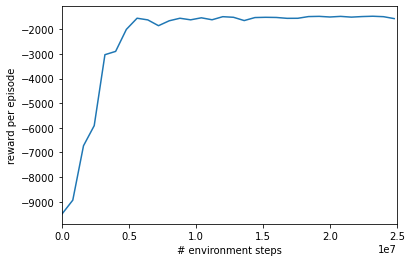

In [1]:
from absl.testing import absltest
from absl.testing import parameterized
from brax import envs
import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output
from brax.training import ars
import time
from datetime import datetime

episode_length = 1000
action_repeat = 1
env_name = 'acrobot'

xdata = []
ydata = []
times = [datetime.now()]
num_timesteps = 25_000_000
auto_reset = True
environment_fn=envs.create_fn(env_name, auto_reset=auto_reset, episode_length=episode_length, action_repeat=action_repeat)

def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics['eval/episode_reward'])
    clear_output(wait=True)
    plt.xlim([0, num_timesteps])
    #plt.ylim([min_y, max_y])
    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.plot(xdata, ydata)
    plt.show()

inference_fn, ars_params, metrics = ars.train(
    environment_fn=environment_fn,
    num_timesteps = num_timesteps, log_frequency=10,
    episode_length = episode_length, normalize_observations = True,
    action_repeat = action_repeat,
    num_eval_envs = 16,
    step_size = 0.03,
    number_of_directions = 40,
    exploration_noise_std=0.025,
    top_directions=30,
    head_type='tanh',
    reward_shift=0.0,
    progress_fn=progress
)


In [2]:
import jax
import jax.numpy as jnp
env = environment_fn()
key = jax.random.PRNGKey(0)
reset_key, inference_key = jax.random.split(key)
state = env.reset(reset_key)
obs = state.obs 

In [3]:
import brax.jumpy as jp
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import linen as nn
import flax

class LinearController(nn.Module):
    obs_size: int
    act_size: int
    use_bias: bool
    
    @nn.compact
    def __call__(self, carry, x):
        a = jnp.tanh(nn.Dense(self.act_size, use_bias=self.use_bias)(x))
        return carry, a

-1468.2781
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

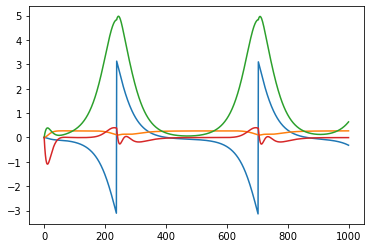

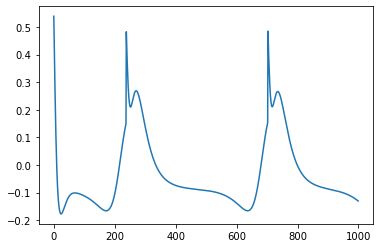

In [4]:
from common import do_local_apg
from brax.training import normalization

normalizer_params, obs_normalizer_update_fn, obs_normalizer_apply_fn = normalization.create_observation_normalizer(
          env.observation_size, normalize_observations=True, num_leading_batch_dims=1)

normalizer_params = ars_params[0]

policy = LinearController(env.observation_size, env.action_size, False)

@jax.jit
def do_rnn_rollout(policy_params, normalizer_params, key):
    init_state = env.reset(key)
    h0 = jp.zeros_like(init_state.obs)

    def do_one_rnn_step(carry, step_idx):
        state, h, policy_params  = carry
        
        normed_obs = obs_normalizer_apply_fn(normalizer_params, state.obs)
        h1 , actions = policy.apply(policy_params, h, normed_obs)
        
        #actions = inference_fn(policy_params, state.obs, key)
        #h1 = h
        
        nstate = env.step(state, actions)    
        return (jax.lax.stop_gradient(nstate), h1, policy_params), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_rnn_step, (init_state, h0, policy_params),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states


init_states =  env.reset(key)
x0 = init_states.obs
h0 = jnp.zeros(env.observation_size)
policy_params = policy.init(key, h0, x0)

policy_params = policy_params.unfreeze()
policy_params['params']['Dense_0']['kernel'] = ars_params[-1]
policy_params = flax.core.frozen_dict.FrozenDict(policy_params)

key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(policy_params, normalizer_params, reset_key)

done_idx = jnp.where(states.done, size=1)[0].item()
if done_idx == 0:
    done_idx = rewards.shape[0]
rewards_sum = jnp.sum(rewards[:done_idx])

plt.plot(obs);
plt.figure()
plt.plot(acts);
print(rewards_sum)
print(states.done)

In [ ]:
from IPython.display import HTML
from brax.io import html

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, 
                          qps, height=height))

qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)

In [ ]:
policy_params_trained, rewards_lists = do_local_apg(200,
                                                    environment_fn, 
                                                    policy.apply, 
                                                    normalizer_params, 
                                                    policy_params, 
                                                    key, 
                                                    3e-4, 
                                                    episode_length, 
                                                    action_repeat, 
                                                    normalize_observations=True, 
                                                    batch_size=8, 
                                                    clipping=1e9, 
                                                    truncation_length=None)




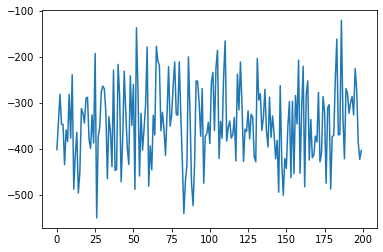

In [7]:
plt.plot(rewards_lists)

In [8]:
key, reset_key = jax.random.split(key)
reward,obs,acts,states = do_rnn_rollout(policy_params, normalizer_params, reset_key)
reward2,obs2,acts2,states2 = do_rnn_rollout(policy_params_trained, normalizer_params, reset_key)
print(sum(reward))
print(sum(reward2))

-222.56374
-225.14973


In [9]:
jnp.any(policy_params['params']['Dense_0']['kernel'] - policy_params_trained['params']['Dense_0']['kernel'])

DeviceArray(True, dtype=bool)

In [ ]:

qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)